#  Word2Vec Model
## Dependencies and Corpus Collation

A vector is a kind of tensor

In [1]:
# dependencies
from __future__ import absolute_import, division, print_function
import codecs
import glob
import multiprocessing
import os
import pprint
import re
import nltk
import gensim.models.word2vec as w2v
import sklearn.manifold
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [ ]:
pip install gensim

In [2]:
# these will need to be the CLTK versions
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/nicklist/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nicklist/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
book_filenames = sorted(glob.glob('/Users/nicklist/nltk_data/corpora/thrones2vec/*.txt')) #file path
print(book_filenames)

['/Users/nicklist/nltk_data/corpora/thrones2vec/got1.txt', '/Users/nicklist/nltk_data/corpora/thrones2vec/got2.txt', '/Users/nicklist/nltk_data/corpora/thrones2vec/got3.txt', '/Users/nicklist/nltk_data/corpora/thrones2vec/got4.txt', '/Users/nicklist/nltk_data/corpora/thrones2vec/got5.txt']


In [4]:
# individual files are placed into one long file (here, called corpus_raw)
# u'' makes it unicode, utf-8 is the unicode format
corpus_raw = u''
for book_filename in book_filenames:
    print("Reading '{0}'...".format(book_filename))
    with codecs.open(book_filename, 'r', 'utf-8') as book_file:
        corpus_raw += book_file.read()
    print('Corpus is now {0} characters long'.format(len(corpus_raw)))
    print()

Reading '/Users/nicklist/nltk_data/corpora/thrones2vec/got1.txt'...
Corpus is now 1770659 characters long

Reading '/Users/nicklist/nltk_data/corpora/thrones2vec/got2.txt'...
Corpus is now 4071041 characters long

Reading '/Users/nicklist/nltk_data/corpora/thrones2vec/got3.txt'...
Corpus is now 6391405 characters long

Reading '/Users/nicklist/nltk_data/corpora/thrones2vec/got4.txt'...
Corpus is now 8107945 characters long

Reading '/Users/nicklist/nltk_data/corpora/thrones2vec/got5.txt'...
Corpus is now 9719485 characters long



In [5]:
# tokenize the file, this will need to be from the CLTK tokenizer
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [6]:
raw_sentences = tokenizer.tokenize(corpus_raw)

In [7]:
# coverts into a list of words
def sentence_to_wordlist(raw):
    clean = re.sub('[^a-zA-Z]', ' ', raw)
    words = clean.split()
    return words

In [8]:
# each sentence contains a list of words that is tokenized
sentences = []
for raw_sentence in raw_sentences:
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence))

In [9]:
# this is just to test the variables 
print(raw_sentences[60])
print(sentence_to_wordlist(raw_sentences[60]))

He let the younger man settle him behind his books and papers.
['He', 'let', 'the', 'younger', 'man', 'settle', 'him', 'behind', 'his', 'books', 'and', 'papers']


In [10]:
token_count = sum([len(sentence) for sentence in sentences])
print('The corpus contains {0:,} tokens'.format(token_count))

The corpus contains 1,818,103 tokens


## Train Word2Vec

Building the model

In [11]:
# This code defines the hyperparameter
# Dimensionality of the resulting word vectors. 
# The more vectors, the more computaionally extensive to train, but also more accurate.
num_features = 300

# Minimum word count threshold.
min_word_count = 3

# Number of threads to run in parallel.
num_workers = multiprocessing.cpu_count()

# Context window length. Note that Munson (2017: 17) says context_size is optimized at 12 for Greek.
context_size = 7

# Downsample setting for frequent words.
#rate 0 and 1e-5 
#how often to use
downsampling = 1e-3

# Seed for the RNG, to make the results reproducible. This is a random number generator
seed = 1

In [12]:
# rename this variable for Greek model
thrones2vec = w2v.Word2Vec(
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

In [13]:
thrones2vec.build_vocab(sentences)

In [15]:
print('Word2Vec vocabulary length:', len(thrones2vec.wv.vocab))

Word2Vec vocabulary length: 17277


In [14]:
#train model on sentneces, this may take a while to process
thrones2vec.train(sentences, total_examples=len(sentences), epochs=100)

(14042932, 18181030)

## Save and Load Model

In [16]:
#save model
if not os.path.exists("trained"):
    os.makedirs("trained")

In [17]:
thrones2vec.save(os.path.join("trained", "thrones2vec.w2v"))

In [18]:
#load model
thrones2vec = w2v.Word2Vec.load(os.path.join("trained", "thrones2vec.w2v"))

## Scatterplot Representation

Currently doesn't work

In [19]:
#squash dimensionality to 2-dimensions
#https://www.oreilly.com/learning/an-illustrated-introduction-to-the-t-sne-algorithm
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)

In [25]:
#put it all into a giant matrix
all_word_vectors_matrix = thrones2vec.wv.syn0

/Users/nicklist/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  


In [26]:
#train t sne
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

In [29]:
#plot point in 2d space
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[thrones2vec.wv.vocab[word].index])
            for word in thrones2vec.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

In [30]:
points.head(10)

,word,x,y
0,This,24.358507,-22.902355
1,edition,-42.260136,-37.119190
2,the,-10.783477,1.124575
3,complete,-3.744561,-16.210197
4,of,-1.642311,6.803561
5,original,1.540604,2.348203
6,hardcover,-41.732502,-36.324223
7,ONE,-32.166512,-42.973785
8,A,5.877848,9.875052
9,OF,-40.745293,-43.516636


In [31]:
#plot
sns.set_context("poster")

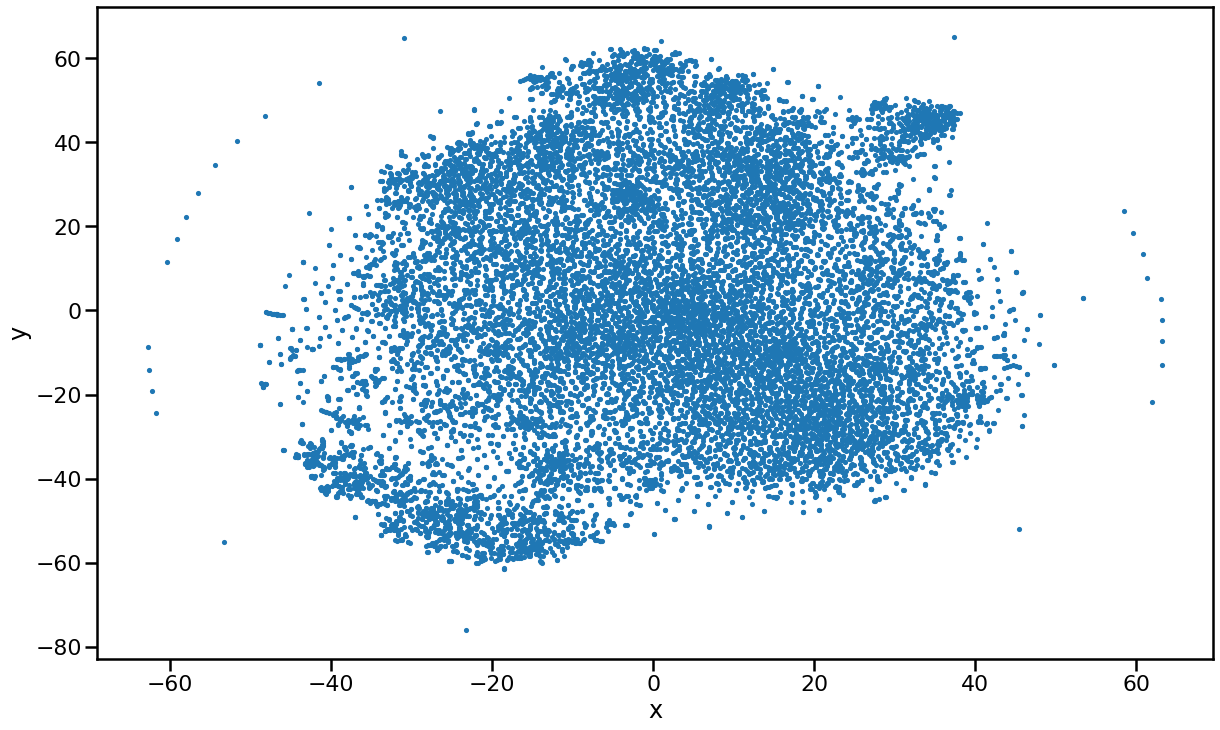

In [32]:
points.plot.scatter("x", "y", s=10, figsize=(20, 12))

In [33]:
# this code zooms in to a part of the scatter plot
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

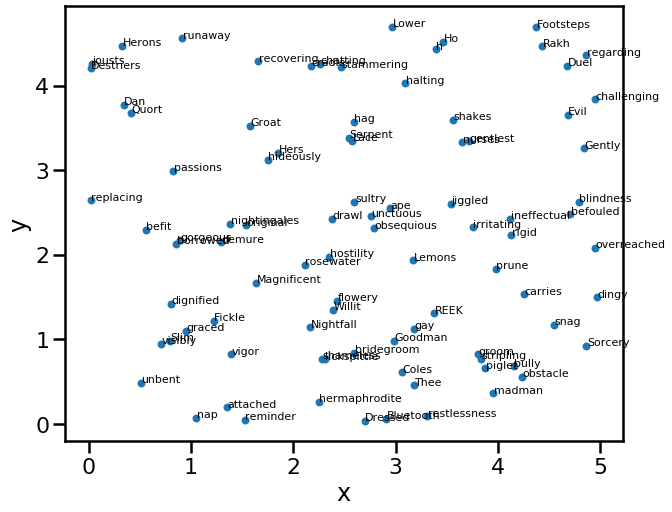

In [52]:
# example coordinates for a particular region, the two numbers in the x_bounds and y_bounds are the parameters
plot_region(x_bounds=(0, 5), y_bounds=(0, --5))

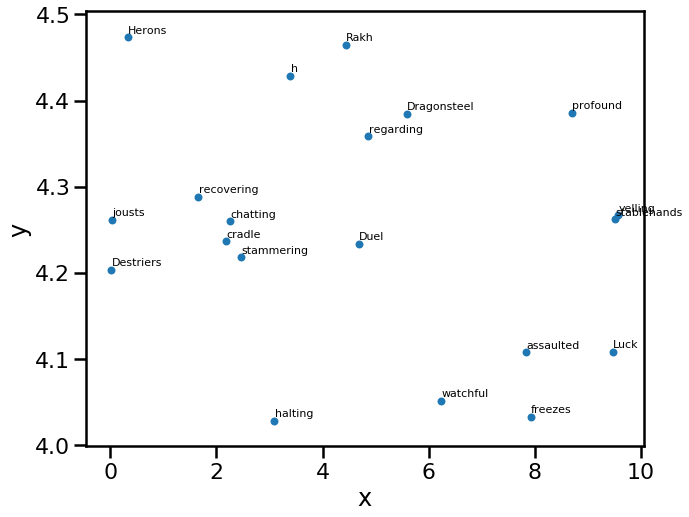

In [43]:
# example coordinates for another region
plot_region(x_bounds=(0, --10), y_bounds=(4, 4.5))

## Functions

In [53]:
# example function, computes the cosine similarity of the vectors
thrones2vec.wv.most_similar("walk")

[('stumble', 0.5578873157501221),
 ('waddle', 0.5443552732467651),
 ('snail', 0.540332019329071),
 ('climb', 0.5388020277023315),
 ('creep', 0.5372892618179321),
 ('disappear', 0.5351471900939941),
 ('swim', 0.532474160194397),
 ('bump', 0.5296885967254639),
 ('Been', 0.527008056640625),
 ('awhile', 0.5256829857826233)]

In [54]:
#distance, similarity, and ranking
def nearest_similarity_cosmul(start1, end1, end2):
    similarities = thrones2vec.wv.most_similar_cosmul(
        positive=[end2, start1],
        negative=[end1]
    )
    start2 = similarities[0][0]
    print("{start1} is related to {end1}, as {start2} is related to {end2}".format(**locals()))
    return start2

In [55]:
nearest_similarity_cosmul("Stark", "Winterfell", "Riverrun")
nearest_similarity_cosmul("Jaime", "sword", "wine")
nearest_similarity_cosmul("Arya", "Nymeria", "dragons")

Stark is related to Winterfell, as Tully is related to Riverrun
Jaime is related to sword, as strongwine is related to wine
Arya is related to Nymeria, as Pay is related to dragons


'Pay'